# Kernel Lesioning

This tutorial showcases how to lesion individual or ensemble of kernels in a deep neural network. We study that in pretrained networks trained on ImageNet.

In neuroscience, the behaviour of the system (humans/animals) is studied when part of a brain is lesioned (either deliberately or because of brain damage). This technique can reveal the functional role of a unit.

A similar technique can be used in artificial neurons to learn more about the representation a network has learnt during its training. **Performing lesioning is much easier in deep networks**:
* We can deliberately lesion one or more kernels.
* We can test the system before and after lesioning.
* We can consider different lesioning paradigms (e.g., setting to zero or noise).
* We can test with numerous stimuli.

Example articles that use this technique:
* [Deciphering image contrast in object classification deep networks](https://www.sciencedirect.com/science/article/pii/S0042698920300766)
* [Brain-like functional specialization emerges spontaneously in deep neural networks](https://www.science.org/doi/full/10.1126/sciadv.abl8913)

## 0. Packages

Let's start with all the necessary packages to implement this tutorial.

 * [numpy](https://numpy.org/) is the main package for scientific computing with Python. It's often imported with the `np` shortcut.
 * [matplotlib](https://matplotlib.org/) is a library to plot graphs in Python.
 * [os](https://docs.python.org/3/library/os.html) provides a portable way of using operating system-dependent functionality, e.g., modifying files/folders.
 * [requests](https://requests.readthedocs.io/en/latest/) is a package that collects several modules for working with URLs.
 * [PIL](https://pillow.readthedocs.io/en/stable/) is a fast image processing designed for general applications.
 * [torch](https://pytorch.org/docs/stable/index.html) is a deep learning framework that allows us to define networks, handle datasets, optimise a loss function, etc.

In [1]:
# importing the necessary packages/libraries
import numpy as np
from matplotlib import pyplot as plt
import random
import os
import requests

from PIL import Image as pil_image

import torch
import torchvision
from torchvision import models
import torchvision.transforms as torch_transforms

### device
Choosing CPU or GPU based on the availability of the hardware.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Stimuli

In this tutorial, we use natural images as our stimuli, but one can show artificial networks any type of stimuli.

We load four images from the internet and show them.

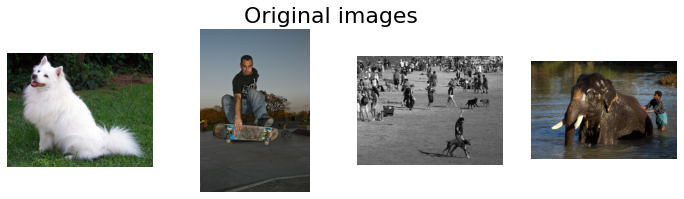

In [3]:
# list of image URLs
urls = [
    'https://github.com/pytorch/hub/raw/master/images/dog.jpg',
    'http://farm4.staticflickr.com/3418/3368475823_74f3d3e9f9_z.jpg', 
    'http://farm3.staticflickr.com/2431/3908162999_5b5cd7c1b7_z.jpg',
    'http://farm8.staticflickr.com/7069/6903096875_042efb5ee7_z.jpg'
]

# Openning the image and visualising it
input_images = [pil_image.open(requests.get(url, stream=True).raw) for url in urls]

fig = plt.figure(figsize=(12, 3))
fig.suptitle('Original images', size=22)
for img_ind, img in enumerate(input_images):
    ax = fig.add_subplot(1, 4, img_ind+1)
    ax.imshow(img)
    ax.axis('off')

### Torch Tensors

Before inputting a network with our images we:
1. **resize** them to what the image size that the pretrained network was trained on,
2. **normalise** them to the range of values that the pretrained network was trained on.

While these two steps are not strictly speaking mandatory, it's sensible to measure the response of kernels under similar conditions that the network is meant to function.

In the end, we visualise the tensor images (after inverting the normalisation). This is often a good exercise to do to ensure what we show to networks is correct.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input tensor shape: torch.Size([4, 3, 224, 224])


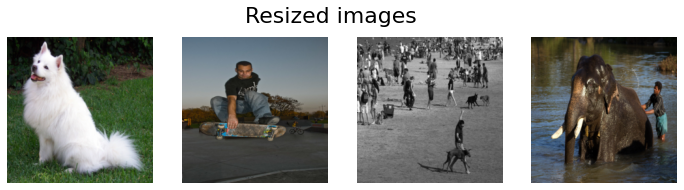

In [4]:
# the training size of ImageNet pretrained networks
target_size = 224
# mean and std values of ImageNet pretrained networks
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# the list of transformation functions
transforsm = torch_transforms.Compose([
    torch_transforms.Resize((target_size, target_size)),
    torch_transforms.ToTensor(),
    torch_transforms.Normalize(mean=mean, std=std)
])

torch_imgs = torch.stack([transforsm(img) for img in input_images])
print("Input tensor shape:", torch_imgs.shape)

# visualising the torch images
fig = plt.figure(figsize=(12, 3))
fig.suptitle('Resized images', size=22)
for img_ind, img in enumerate(torch_imgs):
    ax = fig.add_subplot(1, 4, img_ind+1)
    # inversing the normalisation by multiplying to std and adding mean
    ax.imshow(img.numpy().transpose(1, 2, 0) * std + mean)
    ax.axis('off')

### Performance

Often the impact of lesioning is measured by computing the performance of the network. For instance, how much accuracy in object recognition is dropped if kernel X is lesioned? In order to simulate this in this notebook, we download the ImageNet labels to print the predicted labels of network

In [5]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

--2023-05-31 14:59:49--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.1’

imagenet_classes.tx 100%[===================>]  10,23K  --.-KB/s    in 0s      

2023-05-31 14:59:49 (40,5 MB/s) - ‘imagenet_classes.txt.1’ saved [10472/10472]



## 2. Network

We use [torchvision.models](https://pytorch.org/vision/stable/models.html) to obtain networks pretrained on ImageNet.

In this tutorial, we focus on the `ResNet` architectures, but the logic of computing activation maps remains the same for all other convolutional neural networks (CNN).

Remember that you must call `network.eval()` to set dropout and batch normalisation layers to evaluation mode before recording activation maps. Failing to do this will yield inconsistent results.

In [6]:
network = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1).to(device)
network.eval()

# getting the name of layers, which we use later to lesion
for layer_name, layer_weights in network.state_dict().items():
    print(layer_name, layer_weights.shape)

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
bn1.running_mean torch.Size([64])
bn1.running_var torch.Size([64])
bn1.num_batches_tracked torch.Size([])
layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.bn1.running_mean torch.Size([64])
layer1.0.bn1.running_var torch.Size([64])
layer1.0.bn1.num_batches_tracked torch.Size([])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.0.bn2.running_mean torch.Size([64])
layer1.0.bn2.running_var torch.Size([64])
layer1.0.bn2.num_batches_tracked torch.Size([])
layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight torch.Size([256])
layer1.0.bn3.bias torch.Size([256])
layer1.0.bn3.running_mean torch.Size([256])
layer1.0.bn3.running_var torch.Size([256])
layer1.0.bn3.num_batches_tracked torch.Size([])
layer1.0.downsample.0.weight torch

## 3. Lesion weights

We can implement the lesioning simply by changing the weights of a kernel:

    model.state_dict()[layer_name][kernel_ind] = 0

The code snippet above sets all the weights of kernel number `kernel_ind` at layer `layer_name` to 0. Other possibilities include:
* setting the weights to random numbers,
* setting the weights to a random constant.

**Note**: the original model is modified and any future calling of this model will include the previous lesioning. Therefore, if you want to lesion one kernel at a time, you should each time load the original weights first.

In [7]:
def lesion_kernels(model, kernels=None):
    """Lesioning one or several kernels of a network."""
    for kernel in kernels:
        layer_name, kernel_ind = kernel
        model.state_dict()[layer_name][kernel_ind] = 0
    return model

## 4. Measuring the effect

### Baseline

To correctly interpret the effect of a lesioning, often you compare it to a baseline (the performance with the full network). Therefore, we first print the network predictions without any lesioning.

In [8]:
with torch.no_grad():
    output = network(torch_imgs.cuda())
# The first dimension of our output tensor corresponds to different images, therefore we have to apply the softmax to dim=1
probabilities = torch.nn.functional.softmax(output, dim=1)

# looping through all probabilities and printing the outputs
for img_ind, probability in enumerate(probabilities):
    print('Reporting image number %d' % img_ind)
    top5_prob, top5_catid = torch.topk(probability, 5)
    for i in range(top5_prob.size(0)):
        print('\t %s %.2f' % (categories[top5_catid[i]], top5_prob[i].item()))

Reporting image number 0
	 Samoyed 0.94
	 Pomeranian 0.01
	 Great Pyrenees 0.01
	 white wolf 0.01
	 keeshond 0.01
Reporting image number 1
	 tricycle 0.29
	 barrow 0.24
	 go-kart 0.14
	 racer 0.03
	 lawn mower 0.03
Reporting image number 2
	 Saluki 0.29
	 Afghan hound 0.24
	 bloodhound 0.14
	 miniature pinscher 0.07
	 black-and-tan coonhound 0.03
Reporting image number 3
	 tusker 0.84
	 Indian elephant 0.13
	 African elephant 0.03
	 hippopotamus 0.00
	 warthog 0.00


### Lesioned network

We lesion a few arbitrary kernels across different layers.

In [9]:
network = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1).to(device)
network.eval()

network = lesion_kernels(network, [
    ['conv1.weight', 11], ['conv1.weight', 25],
    ['layer1.0.conv3.weight', 24], ['layer1.1.conv2.weight', 47],
    ['layer2.0.conv1.weight', 63], ['layer2.2.conv1.weight', 111],
    ['layer3.0.conv2.weight', 153], ['layer3.1.conv3.weight', 175],
    ['layer4.0.conv1.weight', 253], ['layer4.1.conv2.weight', 342]
])

We check the weights of one of those layers to ensure the weights are indeed set to zero.

In [10]:
network.state_dict()['conv1.weight'][11]

tensor([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0')

We print again the networks' predictions. We can observe:
* For two of those images (first and last), the output doesn't change much.
* However, for the other two the order of top-2 items changes. For instance, in the second image previously *tricycle* was the first prediction, but now it's *go-kart*, suggesting the lesioned kernels have inhibited certain features useful in the detection of tricycle.

In [11]:
with torch.no_grad():
    output = network(torch_imgs.cuda())
# The first dimension of our output tensor corresponds to different images, therefore we have to apply the softmax to dim=1
probabilities = torch.nn.functional.softmax(output, dim=1)

# looping through all probabilities and printing the outputs
for img_ind, probability in enumerate(probabilities):
    print('Reporting image number %d' % img_ind)
    top5_prob, top5_catid = torch.topk(probability, 5)
    for i in range(top5_prob.size(0)):
        print('\t %s %.2f' % (categories[top5_catid[i]], top5_prob[i].item()))

Reporting image number 0
	 Samoyed 0.95
	 Pomeranian 0.02
	 Great Pyrenees 0.01
	 white wolf 0.00
	 keeshond 0.00
Reporting image number 1
	 go-kart 0.72
	 tricycle 0.11
	 racer 0.03
	 lawn mower 0.03
	 barrow 0.02
Reporting image number 2
	 Afghan hound 0.25
	 parachute 0.09
	 ballplayer 0.07
	 EntleBucher 0.06
	 racket 0.06
Reporting image number 3
	 tusker 0.84
	 Indian elephant 0.13
	 African elephant 0.03
	 hippopotamus 0.00
	 sandbar 0.00


## 5. Systematic experiments

While qualitatively checking the effect of kernel lesioning is interesting and results in some intuition about the underlying representation of deep networks, it's more informative to measure their effect **quantitatively**. Therefore often:
* We compute the performance (e.g., accuracy) over the entire validation set.
* We lesion one kernel at a time to measure the influence of a particular kernel.
* Alternatively, we accumulate lesioned kernels systematically by their order of importance, for instance,
  1. We lesion the kernel that causes the biggest impact
  2. While keeping that kernel lesioned we search for the kernel with the second biggest impact.
  3. We continue this procedure until the performance is dropped to a certain threshold.

It must be noted that the effect of lessening kernels is not accumulative as there are overlaps between the representation of different features. For example:
* Lesioning kernels 1 and 2 (one at a time) results in 2 and 5% performance drops respectively.
* Lesioing bot kernels 1 and 2 does not result in a 7% performance drop,
* Because for example, they both encode a similar colour representation.

**Questions to explore**: kernel lesioning is a powerful technique and one can perform many interesting experiments with it. Below are a few example exercises:
1. **Colour**
   * In the geometrical shape detection, create a test set in which all shapes have a certain colour.
   * Lesion one kernel at a time across all layers.
   * Measure the performance.
   * Are there kernels whose lesions cause significant performance drops?
   * Are colour kernels more present in early or deeper layers?
2. **Size**
   * In the geometrical shape detection, create a test set in which all shapes have a certain size.
   * Lesion one kernel at a time across all layers.
   * Measure the performance.